In [1]:
from rnd import RandomNetworkDistillation

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
import dpdata
import glob
import seaborn as sns
import pandas as pd
import os
import pickle

In [3]:
# load descriptor by pickle
with open('desc.pkl', 'rb') as f:
    desc = pickle.load(f)
desc.shape

(20873, 136)

In [46]:
desc = np.load('desc.npy')

In [ ]:
target_vector = desc.copy()  

# 初始化 RND 模块
input_dim = target_vector.shape[-1]  # 输入维度
output_dim = target_vector.shape[-1]   # 输出维度（与输入维度相同）
hidden_dim = 240  # 隐藏层维度
log_file = "rnd_training.log"  # 日志文件

# RND 训练部分
train_data = target_vector.copy()  

# 初始化 RND 训练器
rnd = RandomNetworkDistillation(input_dim=input_dim, output_dim=input_dim, hidden_dim=hidden_dim, 
                                    num_residual_blocks=3, distance_metric="cossim", use_normalization=False)

# 训练模型
rnd.train(train_data, 
          num_epochs=40, 
          batch_size=4096, 
          initial_lr=1e-3, 
          gamma=0.90, 
          loss_down_step=5, 
          log_file=log_file)

# 保存预测网络和目标网络
rnd.save_predictor_network("rnd_predictor.pth")
rnd.save_target_network("rnd_target.pth")

2025-01-09 13:10:04,714 - INFO - Epoch 1/40 started, learning rate: 0.001000


2025-01-09 13:10:05,070 - INFO - Epoch 1/40 completed, Time: 0.36s, Loss: 0.442151
2025-01-09 13:10:05,071 - INFO - Epoch 2/40 started, learning rate: 0.000900
2025-01-09 13:10:05,372 - INFO - Epoch 2/40 completed, Time: 0.30s, Loss: 0.063314
2025-01-09 13:10:05,373 - INFO - Epoch 3/40 started, learning rate: 0.000900
2025-01-09 13:10:05,708 - INFO - Epoch 3/40 completed, Time: 0.33s, Loss: 0.046979
2025-01-09 13:10:05,708 - INFO - Epoch 4/40 started, learning rate: 0.000900
2025-01-09 13:10:06,025 - INFO - Epoch 4/40 completed, Time: 0.32s, Loss: 0.039483
2025-01-09 13:10:06,026 - INFO - Epoch 5/40 started, learning rate: 0.000900
2025-01-09 13:10:06,325 - INFO - Epoch 5/40 completed, Time: 0.30s, Loss: 0.032550
2025-01-09 13:10:06,326 - INFO - Epoch 6/40 started, learning rate: 0.000900
2025-01-09 13:10:06,620 - INFO - Epoch 6/40 completed, Time: 0.29s, Loss: 0.027105
2025-01-09 13:10:06,621 - INFO - Epoch 7/40 started, learning rate: 0.000810
2025-01-09 13:10:06,920 - INFO - Epoch 7

In [34]:
print(RND.target_network)

RNDNetwork(
  (fc1): Linear(in_features=136, out_features=240, bias=True)
  (residual_blocks): Sequential(
    (0): ResidualBlock(
      (fc1): Linear(in_features=240, out_features=240, bias=True)
      (fc2): Linear(in_features=240, out_features=240, bias=True)
      (relu): ReLU()
    )
  )
  (fc2): Linear(in_features=240, out_features=136, bias=True)
  (relu): ReLU()
)


In [41]:
# 计算每个点的独特性（内在奖励）
intrinsic_rewards = []
batch_size = 4096  # 批量计算以提高性能

# 批量计算内在奖励
for i in range(0, len(target_vector), batch_size):
    batch = target_vector[i:i + batch_size]  # 获取当前批次数据
    batch_rewards = [RND.get_intrinsic_reward(state) for state in batch]  # 计算批次中每个点的内在奖励
    intrinsic_rewards.extend(batch_rewards)

# 将内在奖励转换为 numpy 数组
intrinsic_rewards = np.array(intrinsic_rewards)

# 找到前 1000 个最独特的点
top_1000_indices = np.argsort(intrinsic_rewards)[-1000:]  # 获取奖励值最大的 1000 个索引
top_1000_points = target_vector[top_1000_indices]  # 获取对应的点

# 输出结果
print("前 1000 个最独特的点的索引：", top_1000_indices)

前 1000 个最独特的点的索引： [13841 14779 13010  7518  5834 15394 17419 17363 18912  9960 13848  7974
 19162 11277 13947  9367 10794  9350 13060  8739 13036 11250 13312  7501
 10826 15334 19163 10329 12262 15328  1281  9360  5549 19118  9351 14972
 11197  6732  7511 10333 12270 18288 18347 18327  7993  7678 15956 14806
   836  9358 18855 15444  7514  9359  7517 10328  6501 16013 10397 18931
  8002  5458 11393 17415   400   383   840 19094 19187  9804  1173 10354
  8068 10389 10795  7507 18297 17424 15301 13854 11260   838  9862 10811
  5377 18900 19023 19015 13855 15450 11221  5684  6723 19202 18969  5599
 10121 13840 11263 15706 11317 13318  7450 19192  4193 17591  7503 10400
  7970  3423 15932  7995 19007  5079 16523  4908 19153  7298 19294 11199
  8266 10342 19087 15332 20051 17454 18325  6866 11230  9363 15917 11905
 19307  6505 18280 10312 17421 10355 18890  4513  8005 11219 10808 14772
 11200 18299 11239  3950 12266 11213 14790 12457 14791 10311 11224 10813
   301 19637 18907  9362 11265 10

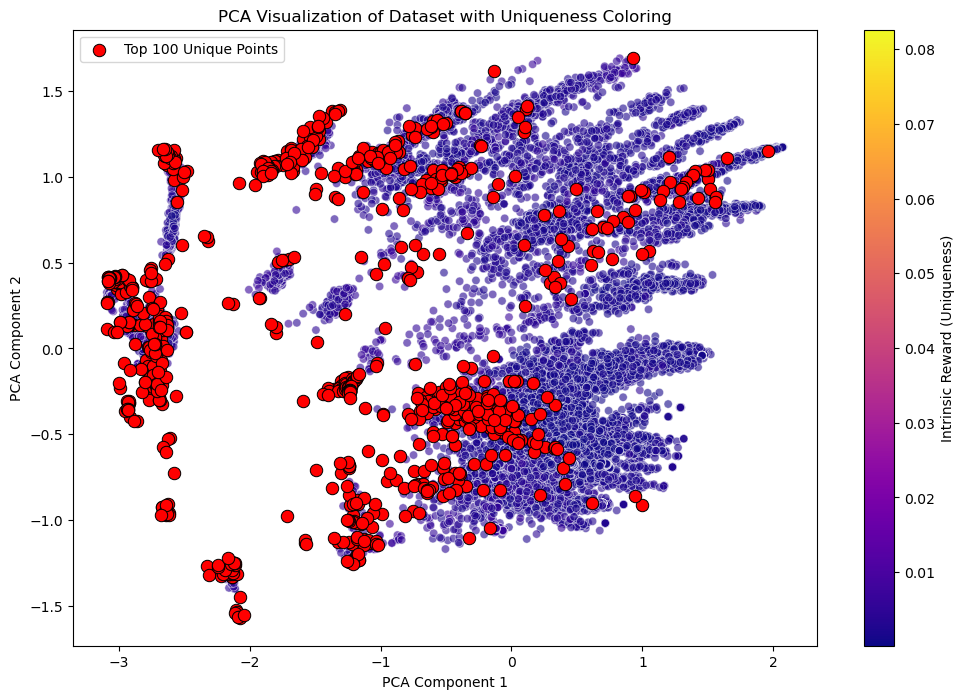

In [42]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt


# PCA 可视化部分
# 使用 PCA 将数据降维到 2D
pca = PCA(n_components=2)  # 降维到 2D
pca_result = pca.fit_transform(target_vector)  # 对整个数据集进行 PCA 降维
top_1000_pca_result = pca.transform(top_1000_points)  # 对前 100 个最独特的点进行 PCA 降维

# 可视化
plt.figure(figsize=(12, 8))

# 绘制所有点，颜色表示独特性度量
ax = sns.scatterplot(
    x=pca_result[:, 0], y=pca_result[:, 1],
    hue=intrinsic_rewards, palette="plasma", alpha=0.6, legend=False
)

# 绘制前 100 个最独特的点，用红色标注
sns.scatterplot(
    x=top_1000_pca_result[:, 0], y=top_1000_pca_result[:, 1],
    color="red", label="Top 100 Unique Points", s=80, edgecolor="black"
)

# 添加颜色条
norm = plt.Normalize(intrinsic_rewards.min(), intrinsic_rewards.max())
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Intrinsic Reward (Uniqueness)")  # 指定 ax 参数

# 添加标题和标签
plt.title("PCA Visualization of Dataset with Uniqueness Coloring")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

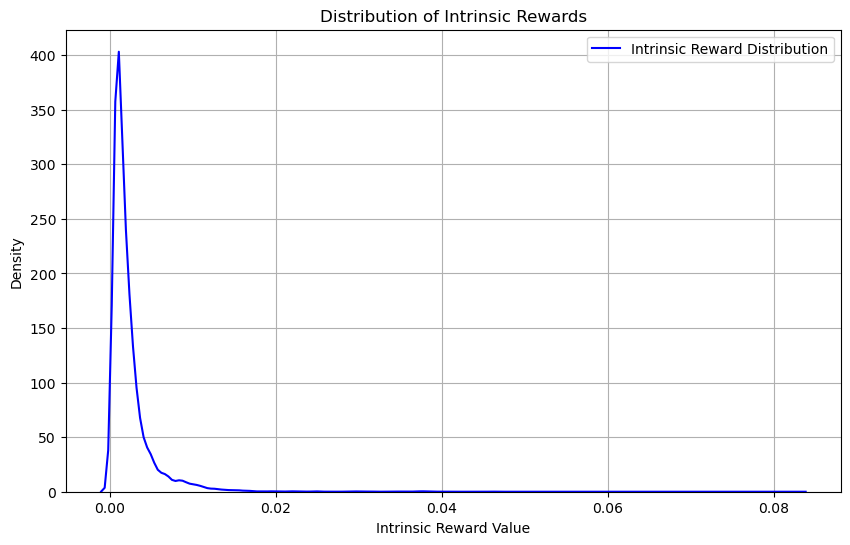

In [43]:
# 绘制内在奖励值的分布曲线图
plt.figure(figsize=(10, 6))
sns.kdeplot(intrinsic_rewards, color="blue", label="Intrinsic Reward Distribution")  # 使用核密度估计绘制分布曲线
plt.title("Distribution of Intrinsic Rewards")
plt.xlabel("Intrinsic Reward Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

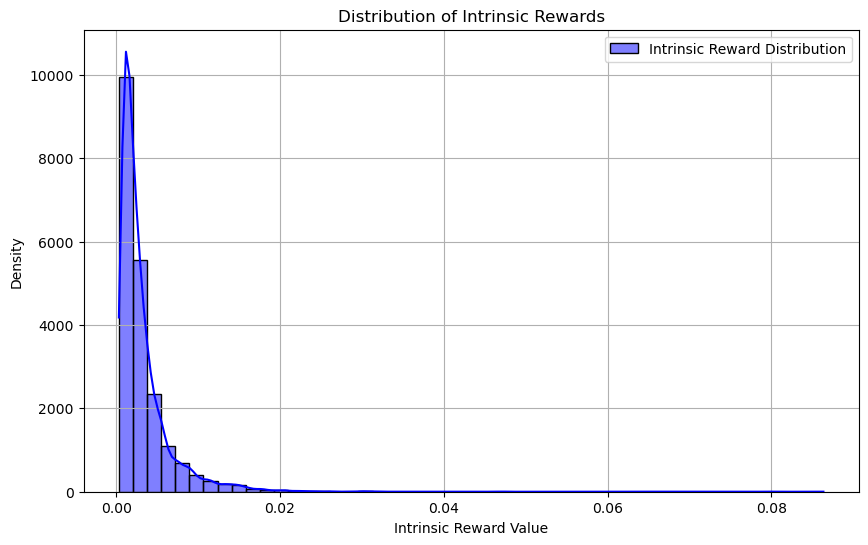

In [39]:
# 直接按照出现频率绘制内在奖励值的分布曲线图
plt.figure(figsize=(10, 6))
#sns.kdeplot(intrinsic_rewards, color="blue", label="Intrinsic Reward Distribution")  # 使用核密度估计绘制分布曲线
sns.histplot(intrinsic_rewards, color="blue", label="Intrinsic Reward Distribution", bins=50, kde=True)
plt.title("Distribution of Intrinsic Rewards")
plt.xlabel("Intrinsic Reward Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()